<a href="https://colab.research.google.com/github/kushvatsa/AML/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

## General information

Upload the solution to canvas. You will get a grade after you've successfully presented it.

*Deadlines and grades*:
* 2021.09.28 - 2021.10.12 ==> 4
* 2021.10.13 - 2021.10.19 ==> 3
* 2021.10.20 - 2021.10.26 ==> 2
* 2021.10.27 or later ==> 1

Note: You can get +1 grade, after you prepare a paper+code presentation, or do an extra task within the 2nd assignment.

## Description

In this assignment you have to build and train a multimodal deep neural network for emotion detection using tf.keras/pytorch. You have to work with the FER2013 dataset, which contains more than 28000 images. The images are automatically gathered, so there can be mislabeled or bad quality samples as well. Do your best!

Every image has a single label from the following list: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral.

## What must be done

You have to train 2 separate models using the original imbalanced and balanced data. Balacing can be done by resampling (undersampling the majority and oversampling the minority classes) or by loss function weighting (bigger error on minority samples).

Therefore the analysis should be done twice, then compare the classification performances and confusion matrices.

## Example pipeline

There is no constraint, you can preprocess the data as you wish, use any DNN (or Transformer architecture) for training, etc. The expected solution should contain data loading and visualization, preprocessing, model definition, training and evaluation.

Here, there is an example pipeline with such details to help you out:
* Download the FER2013 dataset, it is available in csv format at the following link: nipg1.inf.elte.hu:8765/fer2013.csv (if the file is unreachable, write an email)
* You have to solve a classification task.
* Preprocess the data and visualize samples
  * gather the images, separate the train-valid-test subsets (Training, PublicTest, PrivateTest)
  * resize the images: original size is 48x48, networks usually expect e.g. 224x224x3 images. Do the resizing part during data augmentation, otherwise you run out of Colab resources.
  * all images are grayscale with a single value. duplicate the channel dimension if necessary to transform (H,W) to (H,W,3)
  * plot label histogram
* Define train-valid-test dataloaders
  * augment and normalize the input images. (standardize the inputs using the dataset mean/std values, or a preprocess function expected by a pretrained network) - you can use a resize transform to get 240x240x3 images then apply a 224x224x3 randomcrop. 
* Define and train a model
  * define a model (e.g. VGG11 or ResNet18, etc)
  * define the loss function, optimizer
  * use early stopping and a learning rate scheduler
  * train the model using the training and validation subsets
  * plot the training/validation curve
* Evaluation
  * evaluate the model on the test set
  * print/plot classification results and confusion matrix
  * visualize some misclassified samples

At this point, you have the results for the imbalanced case. 

* Balancing
  * Modify it slighthly in the dataloader (resampling) or at loss definition (weighting).
* Compare the classification metrics and confusion matrices

# Use GPU
Runtime -> Change runtime type

At Hardware accelerator select GPU then save it.


# Useful shortcuts
* Run selected cell: *Ctrl + Enter*
* Insert cell below: *Ctrl + M B*
* Insert cell above: *Ctrl + M A*
* Convert to text: *Ctrl + M M*
* Split at cursor: *Ctrl + M -*
* Autocomplete: *Ctrl + Space* or *Tab*
* Move selected cells up: *Ctrl + M J*
* Move selected cells down: *Ctrl + M K*
* Delete selected cells: *Ctrl + M D*

In [1]:
!wget nipg1.inf.elte.hu:8765/fer2013.csv

--2021-10-12 13:22:06--  http://nipg1.inf.elte.hu:8765/fer2013.csv
Resolving nipg1.inf.elte.hu (nipg1.inf.elte.hu)... 157.181.160.161
Connecting to nipg1.inf.elte.hu (nipg1.inf.elte.hu)|157.181.160.161|:8765... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301072766 (287M) [text/csv]
Saving to: ‘fer2013.csv.5’

fer2013.csv.5       100%[===================>] 287.12M  22.4MB/s    in 13s     

2021-10-12 13:22:20 (21.6 MB/s) - ‘fer2013.csv.5’ saved [301072766/301072766]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('fer2013.csv')

In [3]:
data.shape

(35887, 3)

In [4]:
data.head

<bound method NDFrame.head of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 colum

**Splitting Dataset**

In [5]:
train_data = data[data["Usage"]=="Training"]
validation_data = data[data["Usage"]=="PublicTest"]
test_data = data[data["Usage"]=="PrivateTest"]

In [6]:
train_data.shape,test_data.shape,validation_data.shape

((28709, 3), (3589, 3), (3589, 3))

In [7]:
test_data

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [8]:
def toPixels(pixels):

    val = np.array(pixels.split(),"float32")
    return val

In [9]:
train_data["pixels"] = train_data["pixels"].apply(toPixels)
validation_data["pixels"] = validation_data["pixels"].apply(toPixels)
test_data["pixels"] = test_data["pixels"].apply(toPixels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [10]:
test_data

,emotion,pixels,Usage
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ...",PrivateTest
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ...",PrivateTest
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246...",PrivateTest
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111....",PrivateTest
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78....",PrivateTest
...,...,...,...
35882,6,"[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39....",PrivateTest
35883,3,"[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 191...",PrivateTest
35884,0,"[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17....",PrivateTest
35885,3,"[30.0, 28.0, 28.0, 29.0, 31.0, 30.0, 42.0, 68....",PrivateTest


**Images and Labels for 3 datasets**

In [13]:
train_imgs = train_data['pixels']/255
validation_imgs = validation_data['pixels']/255
test_imgs = test_data['pixels']/255

#train_imgs = reshapeImg(train_data)
#validation_imgs = reshapeImg(validation_data)
#test_imgs = reshapeImg(test_data)
train_imgs = train_data['pixels']/255
validation_imgs = validation_data['pixels']/255
test_imgs = test_data['pixels']/255
train_imgs = x_train.astype('float32')
validation_imgs = x_test.astype('float32')
x_valid=x_valid.astype('float32')

train_imgs = train_data['pixels']/255
validation_imgs = validation_data['pixels']/255
test_imgs = test_data['pixels']/255

x_train=x_train/255
x_test=x_test/255
x_valid=x_valid/255

train_labels = train_data["emotion"]
validation_labels = validation_data["emotion"]
test_labels = test_data["emotion"]

In [14]:
train_imgs.shape

(28709,)

In [15]:
def plotImages(x,y):
  for ix in range(4):
      plt.figure(ix)
      plt.imshow(x[ix].reshape((48, 48)), interpolation='none', cmap='gray')
      plt.axis("off")
      plt.show()

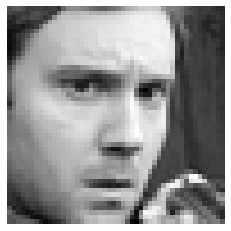

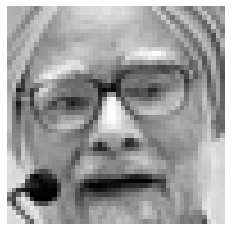

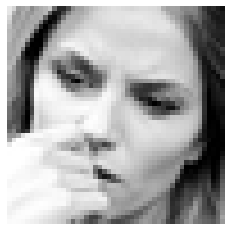

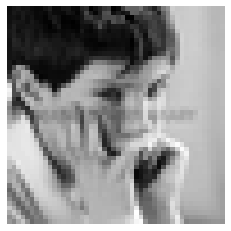

In [16]:
plotImages(train_imgs,train_labels)

In [17]:
def reshapeImg(df):

    imgs = np.reshape(df,(df.shape[0],224,224,3))

    return imgs

In [18]:
newx = train_imgs.transpose()

In [19]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,AveragePooling2D,Dense,Flatten

In [20]:
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(5, 5), activation='relu'))
model.add(AveragePooling2D())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=10, activation = 'softmax'))
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

report=model.fit(train_imgs,train_labels,epochs=50,batch_size=64,validation_data=(validation_imgs,validation_labels))
model.summary()

ValueError: ignored